# MUTUAL FUND INVESTMENT PLAN

### IMPORT LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

### LOAD DATA

In [10]:
file_path = "nifty50_closing_prices.csv"
df = pd.read_csv(file_path)

print("Data Loaded Successfully")
print(df.head())

Data Loaded Successfully
         Date  ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
0  2024-01-01  2914.533936    1038.321777    5727.949707    3327.104004   
1  2024-01-02  2929.719971    1068.593994    5724.263184    3322.450439   
2  2024-01-03  3000.255371    1084.299805    5746.128906    3305.061035   
3  2024-01-04  2995.559814    1112.986572    5740.052734    3311.281982   
4  2024-01-05  3003.852051    1143.754272    5732.133301    3287.377686   

   AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  BHARTIARTL.NS  \
0  1096.853394    6647.077148    1675.343018     659.398193    1007.435730   
1  1092.406982    6611.317871    1685.136841     671.232849    1016.037842   
2  1097.752808    6930.176270    1676.592285     667.144897    1029.463013   
3  1122.533691    6866.345215    1700.876831     696.121582    1042.092651   
4  1136.073120    6922.240723    1708.422119     696.627441    1040.799805   

   ...   SHREECEM.NS  SUNPHARMA.NS  TATAMOTORS.NS  TATA

### DATA CLEANING

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.ffill()

### --------- FEATURE ENGINEERING ----------

In [19]:
df.set_index('Date', inplace=True)

In [21]:
# Monthly returns
returns = df.pct_change().dropna()

In [23]:
# Annualized return
annual_return = returns.mean() * 12

In [25]:
# Volatility (Risk)
volatility = returns.std() * np.sqrt(12)

In [27]:
# Total Return
total_return = (df.iloc[-1] / df.iloc[0]) - 1

### --------- PORTFOLIO CONSTRUCTION ----------

In [29]:
# Select first 3 funds for demo
selected_funds = annual_return.index[:3]
returns_selected = returns[selected_funds]

weights = np.array([0.4, 0.35, 0.25])

In [31]:
# Portfolio return
portfolio_return = np.dot(weights, annual_return[selected_funds])

In [33]:
# Portfolio risk
portfolio_volatility = np.sqrt(
    np.dot(weights.T, np.dot(returns_selected.cov() * 12, weights))
)

In [35]:
print("\nPortfolio Expected Return:", round(portfolio_return * 100, 2), "%")
print("Portfolio Risk (Volatility):", round(portfolio_volatility * 100, 2), "%")


Portfolio Expected Return: 0.68 %
Portfolio Risk (Volatility): 6.74 %


### --------- RISK METRICS ----------

In [41]:
risk_free_rate = 0.05

# Sharpe Ratio
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
print("Sharpe Ratio:", round(sharpe_ratio, 2))

# Sortino Ratio
downside_returns = returns_selected[returns_selected < 0]
downside_risk = downside_returns.std() * np.sqrt(12)
sortino_ratio = (portfolio_return - risk_free_rate) / downside_risk.mean()
print("Sortino Ratio:", round(sortino_ratio, 2))

Sharpe Ratio: -0.64
Sortino Ratio: -0.67


### --------- MONTE CARLO SIMULATION ----------

In [44]:
num_simulations = 1000
num_years = 10

simulation_results = []

for i in range(num_simulations):
    yearly_returns = np.random.normal(
        portfolio_return,
        portfolio_volatility,
        num_years
    )
    simulation_results.append(np.prod(1 + yearly_returns))

simulation_results = np.array(simulation_results)

# --------- VISUALIZATIONS ---------

### Portfolio Growth

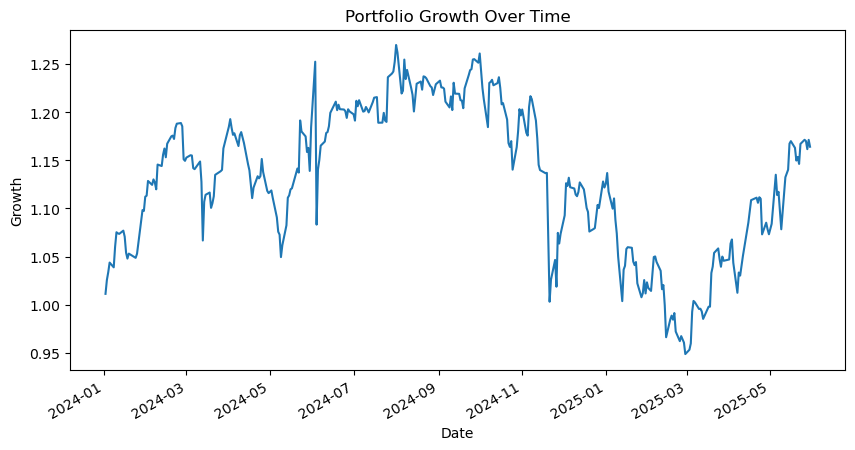

In [55]:
plt.figure(figsize=(10,5))
(1 + returns_selected.mean(axis=1)).cumprod().plot()
plt.title("Portfolio Growth Over Time")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.show()

### Risk vs Return Scatter

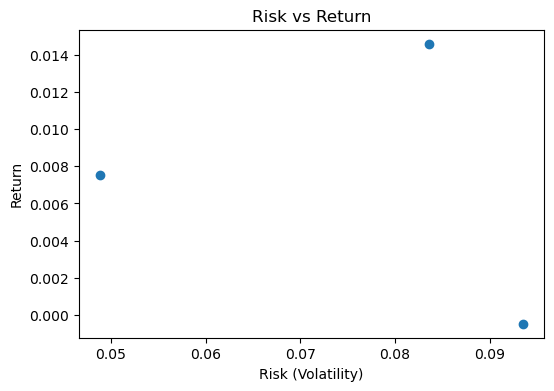

In [58]:
plt.figure(figsize=(6,4))
plt.scatter(volatility[selected_funds], annual_return[selected_funds])
plt.xlabel("Risk (Volatility)")
plt.ylabel("Return")
plt.title("Risk vs Return")
plt.show()

### Portfolio Allocation Pie Chart

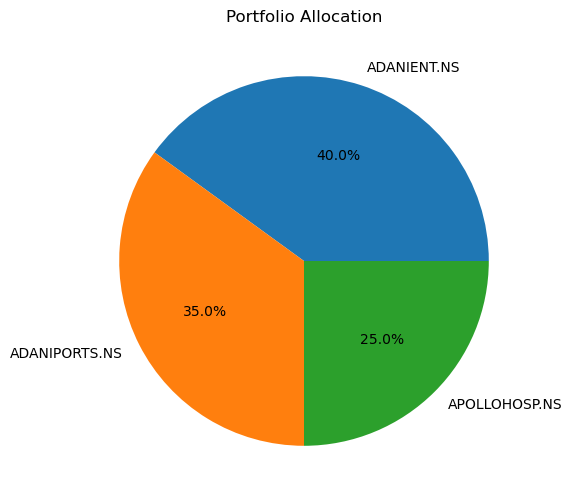

In [61]:
plt.figure(figsize=(6,6))
plt.pie(weights, labels=selected_funds, autopct='%1.1f%%')
plt.title("Portfolio Allocation")
plt.show()

### Correlation Heatmap

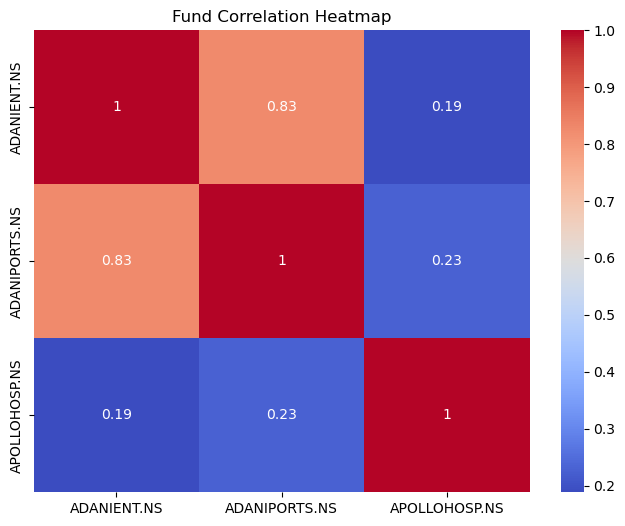

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(returns_selected.corr(), annot=True, cmap="coolwarm")
plt.title("Fund Correlation Heatmap")
plt.show()

### Monte Carlo Histogram

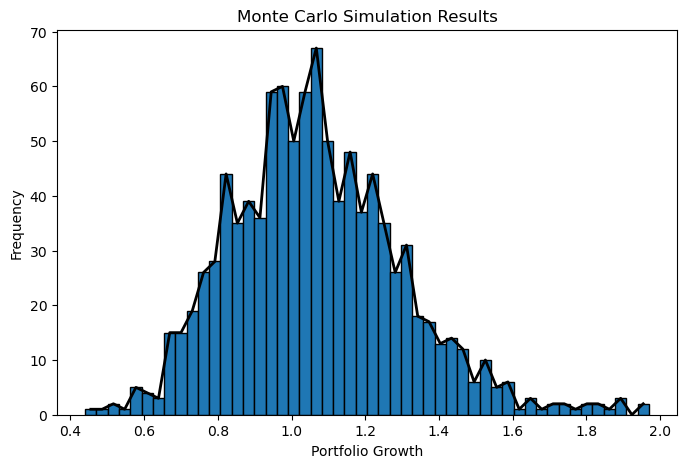

In [86]:
plt.figure(figsize=(8,5))

# Black histogram bars
counts, bins, _ = plt.hist(
    simulation_results,
    bins=50,
    edgecolor='black'
)

# Black line over bars
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, counts, color='black', linewidth=2)

plt.title("Monte Carlo Simulation Results")
plt.xlabel("Portfolio Growth")
plt.ylabel("Frequency")
plt.show()

## --------- MEAN VARIANCE OPTIMIZATION ----------

In [73]:
def portfolio_risk(weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns_selected.cov()*12, weights)))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0,1)] * len(selected_funds)

optimal = minimize(portfolio_risk, weights, bounds=bounds, constraints=constraints)
optimal_weights = optimal.x

print("\nOptimal Portfolio Weights:")
for fund, w in zip(selected_funds, optimal_weights):
    print(f"{fund}: {round(w*100,2)}%")


Optimal Portfolio Weights:
ADANIENT.NS: 6.15%
ADANIPORTS.NS: 13.48%
APOLLOHOSP.NS: 80.37%


## --------- FINAL SUMMARY ----------

In [76]:
print("\n===== INVESTMENT SUMMARY =====")
print("Expected Annual Return:", round(portfolio_return * 100, 2), "%")
print("Portfolio Risk:", round(portfolio_volatility * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Monte Carlo Mean Growth:", round(simulation_results.mean(), 2))
print("================================")


===== INVESTMENT SUMMARY =====
Expected Annual Return: 0.68 %
Portfolio Risk: 6.74 %
Sharpe Ratio: -0.64
Monte Carlo Mean Growth: 1.07
